In [83]:
import tensorflow as tf
import numpy as np
import glob
import os
import re
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline


/home/addepalli/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [84]:
def plotPoke(x):
    f, a = plt.subplots(2, 8, figsize=(13, 3))
    for i in range(8):
        a[0][i].imshow(x[i], cmap=plt.get_cmap('gray'))
        a[0,i].axis('off')
        a[1][i].imshow(x[i+8], cmap=plt.get_cmap('gray'))
        a[1,i].axis('off')
    f.show()
    plt.draw()

In [46]:
#import cv2
#sample = np.zeros([40,40,3],dtype='float32')
#print(sample)
#noise_mask = cv2.randn(sample,(0.5),(0.2))
#print(noise_mask[0][:])
#print(sample[0][:])

[[ 0.51416677  0.          0.        ]
 [ 0.42800248  0.          0.        ]
 [ 0.44986498  0.          0.        ]
 [ 0.74370146  0.          0.        ]
 [ 0.47548267  0.          0.        ]
 [ 0.68313318  0.          0.        ]
 [ 0.51863295  0.          0.        ]
 [ 0.66572845  0.          0.        ]
 [ 0.5995394   0.          0.        ]
 [ 0.54535103  0.          0.        ]
 [ 0.48639089  0.          0.        ]
 [ 0.26455986  0.          0.        ]
 [ 0.83812296  0.          0.        ]
 [ 0.5351789   0.          0.        ]
 [ 0.32644606  0.          0.        ]
 [ 0.45971528  0.          0.        ]
 [ 0.57608855  0.          0.        ]
 [ 0.24341586  0.          0.        ]
 [ 0.567047    0.          0.        ]
 [ 0.21224108  0.          0.        ]
 [ 0.59681028  0.          0.        ]
 [ 0.35957915  0.          0.        ]
 [ 0.41562247  0.          0.        ]
 [ 0.56346148  0.          0.        ]
 [ 0.7447964   0.          0.        ]
 [ 0.69928014  0.        

In [51]:
#noise_mask = np.random.normal(0.5,0.002,(40,40,3))

/home/addepalli/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:402: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


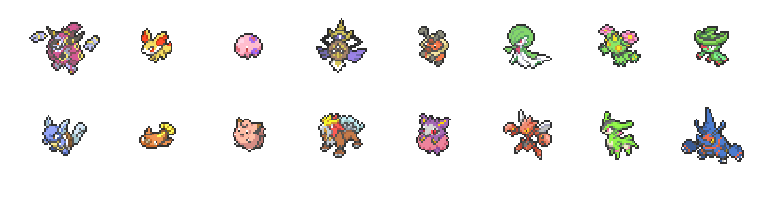

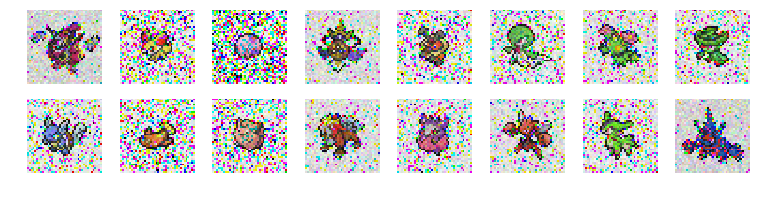

In [85]:
# Create an empty array to store pokemon pics
# this is a list of images, initially it has only no image (size is 40,40,3), we later append the images
orig_img = np.empty((0, 40, 40, 3), dtype='float32')

# Load all images and append into orig_img
path = os.path.abspath("./AE_RGB.ipynb")
path = os.path.dirname(path) + '/'


for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]
    
    # img is an array of the pok iimages and first index is width, then height and then RGBA A is the aplha channel.
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,0:3]
    
    orig_img = np.append(orig_img, [img], axis=0)

# Use plt to show original images 
plotPoke(orig_img)

noisy_img = np.empty((0, 40, 40, 3), dtype='float32')

for pic in glob.glob(path+'Pokemon/*.png'):
    img = mpimg.imread(pic)
    # remove alpha channel  %some alpha=0 but RGB is not equal to [1., 1., 1.]

    # img is an array of the pok iimages and first index is width, then height and then RGBA A is the aplha channel.
    img[img[:,:,3]==0] = np.ones((1,4))
    img = img[:,:,0:3]
    
    noise_mask = np.random.normal(np.mean(img),0.08,(40,40,3))
    img = noise_mask + img
    
    noisy_img = np.append(noisy_img, [img], axis=0)
    
plotPoke(noisy_img)
  

In [ ]:
print(orig_img[0][:][:][8])
print(noisy_img[0][:][:][8])

In [86]:
# Flat all data to one dimension
X_flat = noisy_img.reshape((-1,1600)) 
X_flat_true = orig_img.reshape((-1,1600)) 
    
print ('Original image shape:  {0}\nFlatted image shape:  {1}'.format(orig_img.shape, X_flat.shape))

Original image shape:  (792, 40, 40, 3)
Flatted image shape:  (2376, 1600)


In [87]:
# Transpose RGB channels into 3 different independent image
# Then flatted all pixel into one dimension
print(noisy_img.shape)
X_flat = np.transpose(noisy_img, (0,3,1,2))
X_flat_true = np.transpose(orig_img, (0,3,1,2))

print(X_flat.shape)
X_flat = X_flat.reshape(2376, 1600)
X_flat_true = X_flat_true.reshape(2376, 1600)

print('Original image shape:  {0}\nFlatted image shape:  {1}'.format(orig_img.shape, X_flat.shape))

(792, 40, 40, 3)
(792, 3, 40, 40)
Original image shape:  (792, 40, 40, 3)
Flatted image shape:  (2376, 1600)


In [88]:
# Parameters
learning_rate = 0.001
training_epochs = 30000
batch_size = 36
display_step = 2
examples_to_show = 8

# Network Parameters
n_hidden_1 = 1024
n_hidden_2 = 512
n_hidden_3 = 256
n_input = 1600 # Pokemon input (img shape: 40*40)

In [89]:
# tf Graph input (only pictures)
X_noisy = tf.placeholder("float", [None, n_input])
X_true = tf.placeholder("float", [None, n_input])


weights = {
    'encoder_h1': tf.Variable(tf.truncated_normal([n_input, n_hidden_1], stddev=0.01)),
    'encoder_h2': tf.Variable(tf.truncated_normal([n_hidden_1, n_hidden_2], stddev=0.01)),
    'encoder_h3': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_3], stddev=0.01)),
    'decoder_h1': tf.Variable(tf.truncated_normal([n_hidden_3, n_hidden_2], stddev=0.01)),
    'decoder_h2': tf.Variable(tf.truncated_normal([n_hidden_2, n_hidden_1], stddev=0.01)),
    'decoder_h3': tf.Variable(tf.truncated_normal([n_hidden_1, n_input], stddev=0.01))
}
biases = {
    'encoder_b1': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.01)),
    'encoder_b2': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.01)),
    'encoder_b3': tf.Variable(tf.truncated_normal([n_hidden_3], stddev=0.01)),
    'decoder_b1': tf.Variable(tf.truncated_normal([n_hidden_2], stddev=0.01)),
    'decoder_b2': tf.Variable(tf.truncated_normal([n_hidden_1], stddev=0.01)),
    'decoder_b3': tf.Variable(tf.truncated_normal([n_input], stddev=0.01))
}

# Building the encoder
def encoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']),
                                   biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']),
                                  biases['encoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['encoder_h3']),
                                  biases['encoder_b3']))
    return layer_3

# Building the decoder
def decoder(x):
    # Encoder Hidden layer with sigmoid activation #1
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']),
                                   biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']),
                                   biases['decoder_b2']))
    layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, weights['decoder_h3']),
                                   biases['decoder_b3']))
    return layer_3

In [90]:
# Construct model
encoder_op = encoder(X_noisy)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
# Targets (Labels) are the input data.
y_true = X_true

# Define loss and optimizer, minimize the MSE
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.RMSPropOptimizer(learning_rate).minimize(cost)

In [91]:
# Initializing the variables
init = tf.global_variables_initializer()

# Create session and graph, initial variables
sess = tf.InteractiveSession()
sess.run(init)

In [69]:
# Load previous trained model and rewrite to variables, if exists
# Before run this cell, you have to run the cell above first, to define variables and init it.
weightSaver = tf.train.Saver(var_list=weights)
biaseSaver = tf.train.Saver(var_list=biases)

weightSaver.restore(sess, "./saved_model/AE_RGB_weights.ckpt")
biaseSaver.restore(sess, "./saved_model/AE_RGB_biases.ckpt")

print("Model restored.")

INFO:tensorflow:Restoring parameters from ./saved_model/AE_RGB_weights.ckpt


InvalidArgumentError: Unsuccessful TensorSliceReader constructor: Failed to get matching files on ./saved_model/AE_RGB_weights.ckpt: Not found: ./saved_model
	 [[Node: save/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]

Caused by op 'save/RestoreV2_1', defined at:
  File "/home/addepalli/anaconda3/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/addepalli/anaconda3/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2717, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2821, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2881, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-69-2f8e9aea70b2>", line 3, in <module>
    weightSaver = tf.train.Saver(var_list=weights)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1139, in __init__
    self.build()
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 1170, in build
    restore_sequentially=self._restore_sequentially)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 691, in build
    restore_sequentially, reshape)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 407, in _AddRestoreOps
    tensors = self.restore_op(filename_tensor, saveable, preferred_shard)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tensorflow/python/training/saver.py", line 247, in restore_op
    [spec.tensor.dtype])[0])
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gen_io_ops.py", line 640, in restore_v2
    dtypes=dtypes, name=name)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 767, in apply_op
    op_def=op_def)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 2506, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/home/addepalli/anaconda3/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1269, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): Unsuccessful TensorSliceReader constructor: Failed to get matching files on ./saved_model/AE_RGB_weights.ckpt: Not found: ./saved_model
	 [[Node: save/RestoreV2_1 = RestoreV2[dtypes=[DT_FLOAT], _device="/job:localhost/replica:0/task:0/cpu:0"](_arg_save/Const_0_0, save/RestoreV2_1/tensor_names, save/RestoreV2_1/shape_and_slices)]]


In [92]:
total_batch = int(X_flat.shape[0]/batch_size)
# Training cycle
for epoch in range(3000):
    # Loop over all batches
    start = 0; end = batch_size
    for i in range(total_batch-1):
        index = np.arange(start, end)
        np.random.shuffle(index)
        batch_xs = X_flat[index]
        batch_xs_true = X_flat_true[index]
        start = end; end = start+batch_size
        # Run optimization op (backprop) and loss op (to get loss value)
        _, c = sess.run([optimizer, cost], feed_dict={X_noisy: batch_xs, X_true: batch_xs_true})
    # Display logs per epoch step
    if ((epoch == 0) or (epoch+1) % display_step == 0) or ((epoch+1) == training_epochs):
        print('Epoch: {0:05d}   loss: {1:f}'.format(epoch+1, c))

print("Optimization Finished!")

Epoch: 00001   loss: 0.215350
Epoch: 00002   loss: 0.126378
Epoch: 00004   loss: 0.032605
Epoch: 00006   loss: 0.031853
Epoch: 00008   loss: 0.031557


KeyboardInterrupt: 

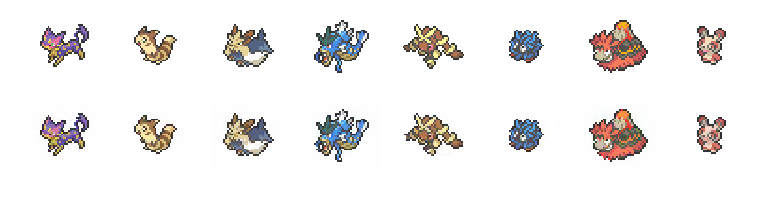

In [11]:
# Random select some pokemon to visualization
# index are picked in orig_img.shape[0], then transform to X_flat with correspond RGB row
index = np.random.randint(orig_img.shape[0], size=examples_to_show)
index = np.sort(index)
RGB_index = np.concatenate((index*3, index*3+1, index*3+2))
RGB_index = np.sort(RGB_index)
autoencoder = sess.run(
    y_pred, feed_dict={X: X_flat[RGB_index]})

# merge RGB rows back to RGB matrix
autoencoder = np.reshape(autoencoder, (examples_to_show, 3, 40, 40))
autoencoder = np.transpose(autoencoder, (0,2,3,1))

# Compare original images with their reconstructions
f, a = plt.subplots(2, examples_to_show, figsize=(13, 3))
for i in range(examples_to_show):
    a[0][i].imshow(orig_img[index[i]])
    a[0,i].axis('off')
    a[1][i].imshow(autoencoder[i])
    a[1,i].axis('off')
f.show()
plt.draw()

In [12]:
# Save weights and biases
weights_saver = tf.train.Saver(var_list=weights)
biases_saver = tf.train.Saver(var_list=biases)
weights_saver.save(sess, './saved_model/AE_RGB_weights')
biases_saver.save(sess, './saved_model/AE_RGB_biases')

'AE_RGB_biases'